In [21]:
import ee
import geemap
import pandas as pd
import csv
import os

# Initialize
try:
    ee.Initialize(project='absolute-accord-418108')
except Exception:
    ee.Authenticate()
    ee.Initialize(project='absolute-accord-418108')

# --- 1. ROI: BUDAPEST BOUNDARY ---
roi = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Budapest')) \
    .geometry()

# --- 2. DATA INGESTION & PREPROCESSING ---
START_DATE = '2025-06-01'
END_DATE = '2025-09-01'

def preprocess_s5p(image):
    # Filter for clouds (approximate using cloud fraction)
    # The official QA band is preferred, but cloud_fraction < 0.3 is a standard proxy
    return image.updateMask(image.select('cloud_fraction').lt(0.3))

collection = (ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2')
              .filterBounds(roi)
              .filterDate(START_DATE, END_DATE)
              .map(preprocess_s5p)
              .select(['tropospheric_NO2_column_number_density']))

In [22]:
# --- 3. DAILY MOSAICKING ---
# This ensures days with 2 overlapping orbits are averaged into 1 single layer
def create_daily_composites(collection):
    # Get list of unique dates (normalized to midnight)
    dates = collection.aggregate_array('system:time_start')

    def normalize_date(date_ms):
        return ee.Date(date_ms).format('YYYY-MM-dd')

    unique_dates_str = dates.map(normalize_date).distinct()

    def compute_daily_mean(date_str):
        date_start = ee.Date(date_str)
        date_end = date_start.advance(1, 'day')

        # Filter for this specific day
        daily_imgs = collection.filterDate(date_start, date_end)

        # Mean of overlaps (handles the orbit issue)
        daily_mosaic = daily_imgs.mean().set({
            'system:time_start': date_start.millis(),
            'date_str': date_str,
            # Calculate DOW here for the mosaic
            'dow': date_start.getRelative('day', 'week').add(1)
        })
        return daily_mosaic.setDefaultProjection(daily_imgs.first().projection())

    return ee.ImageCollection(unique_dates_str.map(compute_daily_mean))

# Now we have a clean Daily Collection
daily_col = create_daily_composites(collection)

In [23]:
# --- 4. MAP VISUALIZATION LOGIC ---

# Filter Weekdays (1-5) vs Weekends (6-7) FROM THE CLEAN DAILY COLLECTION
weekday_col = daily_col.filter(ee.Filter.rangeContains('dow', 1, 5))
weekend_col = daily_col.filter(ee.Filter.rangeContains('dow', 6, 7))

# Calculate Means
weekday_mean = weekday_col.mean().clip(roi)
weekend_mean = weekend_col.mean().clip(roi)

# Calculate % Drop
diff = weekday_mean.subtract(weekend_mean)
percent_drop = diff.divide(weekday_mean).multiply(100).rename('no2_reduction_pct')

# --- 5. RENDER THE MAP ---
m = geemap.Map()
m.centerObject(roi, 10)

# Viz Params
no2_viz = {'min': 0, 'max': 0.00015, 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}
drop_viz = {'min': 0, 'max': 50, 'palette': ['white', 'yellow', 'orange', 'red']}

m.addLayer(weekday_mean, no2_viz, 'Weekday Mean NO2')
m.addLayer(percent_drop, drop_viz, 'Weekend Effect (% Drop)')

# Add boundary outline for context
m.addLayer(ee.Image().paint(roi, 0, 2), {'palette': 'black'}, 'Budapest City Limit')
m

Map(center=[47.47656979142398, 19.112804947625232], controls=(WidgetControl(options=['position', 'transparent_…

In [24]:
# --- 6. CSV EXPORT LOGIC ---
# We use the SAME 'daily_col' we created in Step 3, ensuring consistency.

def extract_and_export(image_col, geometry, filename='budapest_no2_stats.csv'):

    def get_stats(img):
        # Reduce region over the irregular Budapest polygon
        stats = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=1000, # Higher resolution for city-level
            maxPixels=1e9
        )
        return ee.Feature(None, {
            'date': img.get('date_str'),
            'dow': img.get('dow'),
            'no2_mol_m2': stats.get('tropospheric_NO2_column_number_density')
        })

    # Extract
    print("Extracting statistics...")
    data_list = image_col.map(get_stats).filter(ee.Filter.notNull(['no2_mol_m2'])).getInfo()['features']

    # Write CSV
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['date', 'dow', 'day_name', 'no2_mol_m2', 'regime'])

        dow_map = {1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun'}

        for item in data_list:
            p = item['properties']
            writer.writerow([
                p['date'],
                p['dow'],
                dow_map.get(p['dow']),
                p['no2_mol_m2'],
                'Weekend' if p['dow'] >= 6 else 'Weekday'
            ])
    print(f"Export complete: {os.path.abspath(filename)}")

# Export
extract_and_export(daily_col, roi)

Extracting statistics...
Export complete: /content/budapest_no2_stats.csv


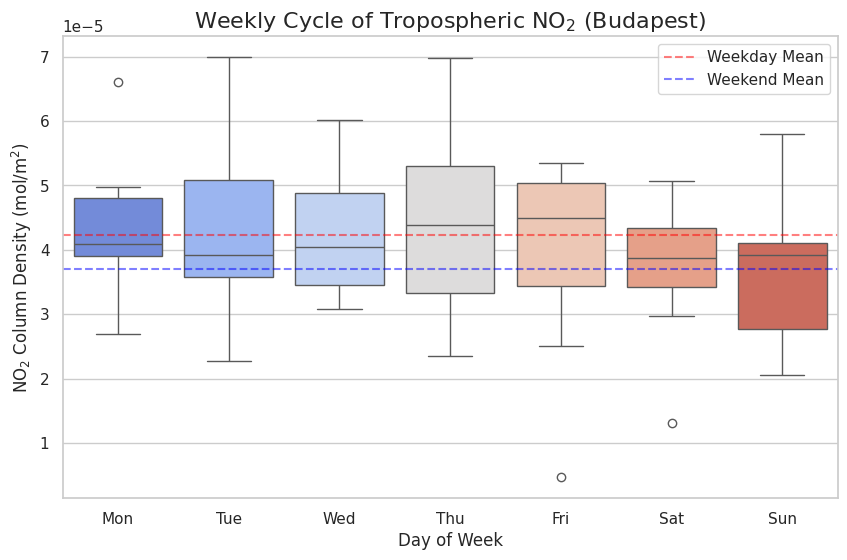

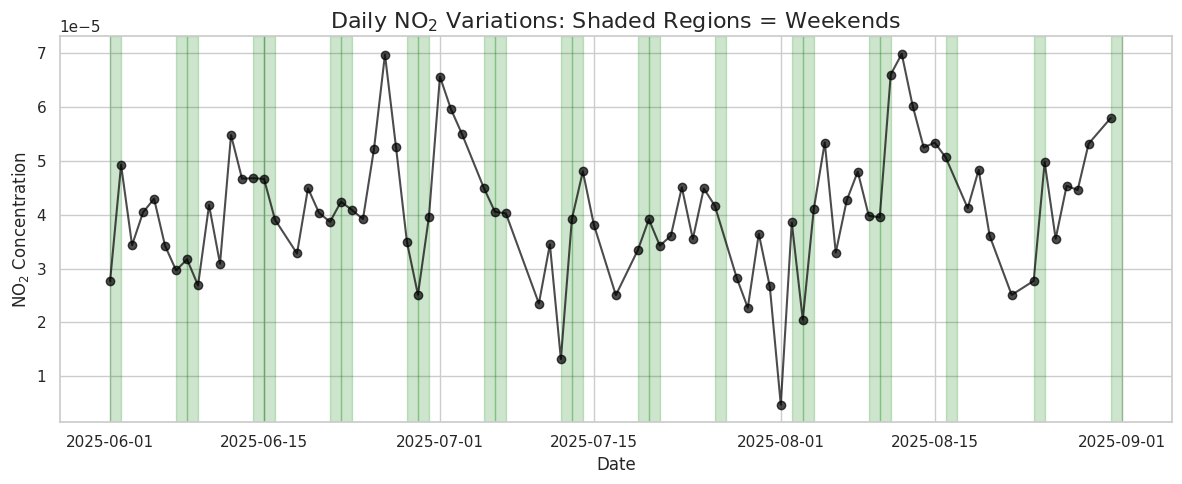

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# --- 6. DATA EXTRACTION FOR CHARTS ---
# We need to extract the time-series data from the ROI to plot it.
# We calculate the mean NO2 over the ROI for every image in the collection.

def get_roi_mean(img):
    # Calculate spatial mean over the ROI
    mean_val = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=5000, # S5P resolution is roughly 3.5x7km, so 5km is safe
        maxPixels=1e9
    ).get('tropospheric_NO2_column_number_density')

    # Return feature with properties for the chart
    return ee.Feature(None, {
        'date': img.date().format('YYYY-MM-dd'),
        'dow': img.get('dow'), # We added this in step 3
        'no2': mean_val
    })

# Map this over the collection (this happens on the server)
time_series = daily_col.map(get_roi_mean)

# Transfer data to Client-side (Python List)
# Note: getInfo() can be slow for massive collections, but okay for a few months of data
data = time_series.getInfo()['features']

# Convert to Pandas DataFrame
df = pd.DataFrame([feat['properties'] for feat in data])
df['date'] = pd.to_datetime(df['date'])
df['dow_name'] = df['dow'].map({1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun'})
# Remove any None/NaN values (cloudy days)
df = df.dropna()

# --- 7. VISUAL 1: THE WEEKLY CYCLE BOXPLOT ---
# This is the "Money Plot" for weekend effect studies.
# It shows the statistical distribution of NO2 for each day of the week.

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Create Boxplot
ax = sns.boxplot(x='dow_name', y='no2', data=df,
                 order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                 palette="coolwarm")

plt.title('Weekly Cycle of Tropospheric NO$_2$ (Budapest)', fontsize=16)
plt.ylabel('NO$_2$ Column Density (mol/m$^2$)', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)

# Add a line showing the mean to emphasize the drop
weekday_avg = df[df['dow'] <= 5]['no2'].mean()
weekend_avg = df[df['dow'] > 5]['no2'].mean()
plt.axhline(weekday_avg, color='red', linestyle='--', alpha=0.5, label='Weekday Mean')
plt.axhline(weekend_avg, color='blue', linestyle='--', alpha=0.5, label='Weekend Mean')
plt.legend()

plt.show()

# --- 8. VISUAL 2: TIME SERIES WITH REGIME SHADING ---
# Visualizing the raw data over time, shading the weekends to highlight the dips.

plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['no2'], marker='o', linestyle='-', color='black', alpha=0.7)

# Highlight weekends
# We iterate through the dates to shade Saturdays and Sundays
for i, row in df.iterrows():
    if row['dow'] >= 6:
        plt.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), color='green', alpha=0.2)

plt.title('Daily NO$_2$ Variations: Shaded Regions = Weekends', fontsize=16)
plt.ylabel('NO$_2$ Concentration', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

--- Descriptive Statistics ---
Weekday Mean: 4.33e-05 mol/m^2 (n=58)
Weekend Mean: 3.78e-05 mol/m^2 (n=23)
Absolute Drop: 5.50e-06
Relative Drop: 12.71%
------------------------------
--- T-Test Results ---
T-statistic: 1.9840
P-value:     5.2715e-02

❌ RESULT: Not Statistically Significant.
   The difference could be due to random chance (weather/noise).


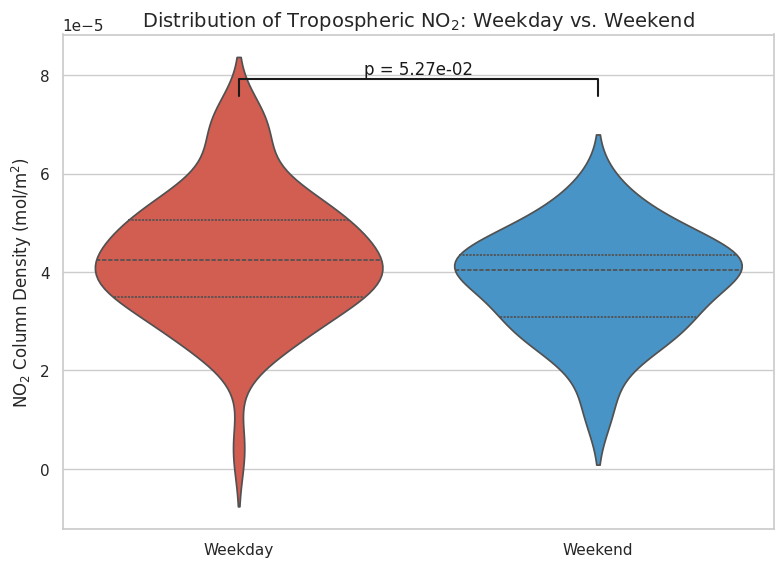

In [27]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. LOAD DATA ---
# Load the clean daily composite data we just exported
df = pd.read_csv('budapest_no2_stats.csv')

# Separate the populations
weekdays = df[df['regime'] == 'Weekday']['no2_mol_m2']
weekends = df[df['regime'] == 'Weekend']['no2_mol_m2']

# --- 2. DESCRIPTIVE STATISTICS ---
print(f"--- Descriptive Statistics ---")
print(f"Weekday Mean: {weekdays.mean():.2e} mol/m^2 (n={len(weekdays)})")
print(f"Weekend Mean: {weekends.mean():.2e} mol/m^2 (n={len(weekends)})")
print(f"Absolute Drop: {weekdays.mean() - weekends.mean():.2e}")
print(f"Relative Drop: {((weekdays.mean() - weekends.mean()) / weekdays.mean()) * 100:.2f}%")
print("-" * 30)

# --- 3. INFERENTIAL STATISTICS (T-TEST) ---
# We use Welch's t-test (equal_var=False) because weekend weather variance
# might differ from weekday variance.
t_stat, p_val = stats.ttest_ind(weekdays, weekends, equal_var=False)

print(f"--- T-Test Results ---")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value:     {p_val:.4e}")  # Scientific notation for very small numbers

# Interpretation logic for the console output
alpha = 0.05
if p_val < alpha:
    print("\n✅ RESULT: Statistically Significant Difference.")
    print("   We reject the null hypothesis. The 'Weekend Effect' is real.")
else:
    print("\n❌ RESULT: Not Statistically Significant.")
    print("   The difference could be due to random chance (weather/noise).")

# --- 4. PUBLICATION-READY VISUALIZATION (VIOLIN PLOT) ---
# A Violin plot is better than a boxplot because it shows the probability density
# (e.g., if there are two 'modes' of pollution levels).

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Create the plot
ax = sns.violinplot(x='regime', y='no2_mol_m2', data=df,
                    order=['Weekday', 'Weekend'],
                    palette={'Weekday': '#e74c3c', 'Weekend': '#3498db'},
                    inner='quartile') # Shows quartiles inside the violin

# Add significance bracket (Research Standard)
# We draw a line between the two groups and label it with the p-value
y_max = df['no2_mol_m2'].max()
h = y_max * 0.05
col = 'k'

x1, x2 = 0, 1   # Columns (Weekday vs Weekend)
y, h = df['no2_mol_m2'].max() + h, h

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, f"p = {p_val:.2e}", ha='center', va='bottom', color=col)

plt.title('Distribution of Tropospheric NO$_2$: Weekday vs. Weekend', fontsize=14)
plt.ylabel('NO$_2$ Column Density (mol/m$^2$)', fontsize=12)
plt.xlabel('') # Regime is self-explanatory

plt.tight_layout()
plt.show()